# Developer tendencies in 2021 - A data based appproach

The analysis will be performed with the data obtained from the Stack Overflow survey performed each year. If want to check the information in detail please refer to: https://insights.stackoverflow.com/survey

## Question of interest

This project will perform an analysis on the developer tendencies regarding several aspects, where the main questons targeted to be answered are the next ones:

1. Which are the most used programming languages and which are the higher paid?
2. From years of coding, years of pro coding or education level, which generates the highest salary?
3. Which way to learn gives the biggest salary? In which type of companies each of these ways to learn people work?

### Data entry 
Firstly, the dataset was reviewed to understand in detail the information we have. 

In [369]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

from currency_converter import CurrencyConverter
c = CurrencyConverter()

%matplotlib inline

# Pandas settings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
#pd.options.display.max_rows = 100

# Plot settings
figure(figsize=(20, 14), dpi=80)

# Data import
survey_2021 = pd.read_csv('survey_results_public_2021.csv')

print("Survey 2021 columns: ", survey_2021.dtypes, "\n")
survey_2021.head()

Survey 2021 columns:  ResponseId                        int64
MainBranch                       object
Employment                       object
Country                          object
US_State                         object
UK_Country                       object
EdLevel                          object
Age1stCode                       object
LearnCode                        object
YearsCode                        object
YearsCodePro                     object
DevType                          object
OrgSize                          object
Currency                         object
CompTotal                       float64
CompFreq                         object
LanguageHaveWorkedWith           object
LanguageWantToWorkWith           object
DatabaseHaveWorkedWith           object
DatabaseWantToWorkWith           object
PlatformHaveWorkedWith           object
PlatformWantToWorkWith           object
WebframeHaveWorkedWith           object
WebframeWantToWorkWith           object
MiscTechHaveWorked

ResponseId                                         MainBranch  \
0           1                     I am a developer by profession   
1           2             I am a student who is learning to code   
2           3  I am not primarily a developer, but I write co...   
3           4                     I am a developer by profession   
4           5                     I am a developer by profession   

                                          Employment  \
0  Independent contractor, freelancer, or self-em...   
1                                 Student, full-time   
2                                 Student, full-time   
3                                 Employed full-time   
4  Independent contractor, freelancer, or self-em...   

                                             Country US_State UK_Country  \
0                                           Slovakia      NaN        NaN   
1                                        Netherlands      NaN        NaN   
2                                 Russian Federation      NaN        NaN   
3                                            Austria      NaN        NaN   
4  United Kingdom of Great Britain and Northern I...      NaN    England   

                                             EdLevel     Age1stCode  \
0  Secondary school (e.g. American high school, G...  18 - 24 years   
1       Bachelor’s degree (B.A., B.S., B.Eng., etc.)  11 - 17 years   
2       Bachelor’s degree (B.A., B.S., B.Eng., etc.)  11 - 17 years   
3    Master’s degree (M.A., M.S., M.Eng., MBA, etc.)  11 - 17 years   
4    Master’s degree (M.A., M.S., M.Eng., MBA, etc.)   5 - 10 years   

                                           LearnCode YearsCode YearsCodePro  \
0  Coding Bootcamp;Other online resources (ex: vi...       NaN          NaN   
1  Other online resources (ex: videos, blogs, etc...         7          NaN   
2  Other online resources (ex: videos, blogs, etc...       NaN          NaN   
3                                                NaN       NaN          NaN   
4                            Friend or family member        17           10   

                                             DevType  \
0                                  Developer, mobile   
1                                                NaN   
2                                                NaN   
3                               Developer, front-end   
4  Developer, desktop or enterprise applications;...   

                                             OrgSize             Currency  \
0                                 20 to 99 employees    EUR European Euro   
1                                                NaN                  NaN   
2                                                NaN                  NaN   
3                               100 to 499 employees    EUR European Euro   
4  Just me - I am a freelancer, sole proprietor, ...  GBP\tPound sterling   

   CompTotal CompFreq                         LanguageHaveWorkedWith  \
0     4800.0  Monthly  C++;HTML/CSS;JavaScript;Objective-C;PHP;Swift   
1        NaN      NaN                              JavaScript;Python   
2        NaN      NaN                       Assembly;C;Python;R;Rust   
3        NaN  Monthly                          JavaScript;TypeScript   
4        NaN      NaN                 Bash/Shell;HTML/CSS;Python;SQL   

           LanguageWantToWorkWith          DatabaseHaveWorkedWith  \
0                           Swift               PostgreSQL;SQLite   
1                             NaN                      PostgreSQL   
2               Julia;Python;Rust                          SQLite   
3           JavaScript;TypeScript                             NaN   
4  Bash/Shell;HTML/CSS;Python;SQL  Elasticsearch;PostgreSQL;Redis   

                     DatabaseWantToWorkWith PlatformHaveWorkedWith  \
0                                    SQLite                    NaN   
1                                       NaN                    NaN   
2                                    SQL

<Figure size 1600x1120 with 0 Axes>

In [361]:
# Data Cleaning

survey_2021.dropna(subset=['CompTotal','LanguageHaveWorkedWith'],inplace=True) # Drop NA's from compensation
survey_2021.drop(survey_2021[survey_2021.Currency == "none\tCook Islands dollar"].index, inplace=True) # Delete currency without acronym

survey_2021['CurrencyAcronim'] = survey_2021.apply(lambda row: row['Currency'][:3],axis=1) # Get only the currency acronim for conversion
survey_2021.drop(survey_2021[~survey_2021.CurrencyAcronim.isin(c.currencies)].index, inplace=True) # Delete non supported currencies for conversion

survey_2021['MonthlyCompensation'] = survey_2021.apply(lambda row: get_monthly_compensation(row['CompFreq'], row['CompTotal']), axis=1) # Get monthly compensation
survey_2021['USDCompensation'] = survey_2021.apply(lambda row: c.convert(row['MonthlyCompensation'],row['CurrencyAcronim'],'USD'), axis=1) # Get USD compensation


In [364]:
# Functions needed to implement

test_df = survey_2021.head(2)

flag = 0
globaldf = pd.DataFrame()

def get_average_df(df, categorycolumn, averagecolumn, categoryname, averagename):
    global flag
    global globaldf
    
    if flag == 0:
        globaldf = pd.DataFrame(columns=[categoryname,'Count',averagename]) # Create dataframe
        flag = 1
    
    start_index = 0
    categories_count = categorycolumn.count(';') + 1 # Count the categories in the row
    
    for i in range(categories_count):
        
        if i!=0: 
            start_index = end_index + 1
        
        if i+1 == categories_count:
            end_index = len(categorycolumn)
        else:
            end_index = categorycolumn.find(';', start_index+1, len(categorycolumn))
            
        language = categorycolumn[start_index:end_index]

        if language in df.value_counts():
            df_index = globaldf.index[globaldf[categoryname] == language].tolist()
            globaldf[averagename][df_index] = (globaldf[averagename][df_index] + averagecolumn) / 2
            globaldf['Count'][df_index] = globaldf['Count'][df_index] + 1
        else:
            dict = {categoryname: language, 'Count': 1, averagename: averagecolumn}
            globaldf = globaldf.append(dict, ignore_index = True)
        
def get_monthly_compensation(frequency, compensation):
    
    if frequency == 'Yearly':
        monthly_comp = compensation / 12
    elif frequency == 'Weekly':
        monthly_comp = compensation * 4
    else: 
        monthly_comp = compensation
        
    return monthly_comp

def normalize_column(column):    
    (column - column.mean()) / (column.max() - column.min())

Language  Count  Average compensation
0           C++   7753          3.728020e+03
1      HTML/CSS  23291          1.836906e+03
2    JavaScript  28505          1.880673e+04
3   Objective-C   1317          7.890445e+03
4           PHP   8625          2.480667e+03
5         Swift   2236          1.100783e+04
6        Python  18385          5.963501e+04
7    Bash/Shell  13161          3.753233e+04
8       Node.js  14890          3.640325e+04
9           SQL  21624          1.100075e+04
10   TypeScript  15291          4.055361e+03
11            C   6421          5.428426e+03
12         Java  13541          2.464030e+04
13         Perl   1194          1.102725e+04
14         Ruby   3675          7.028785e+03
15           C#  12537          3.572678e+03
16       Kotlin   3540          7.965092e+03
17       Delphi    947          1.953389e+03
18           Go   4741          8.651805e+03
19        Scala   1345          4.761190e+03
20     Assembly   1507          1.025327e+04
21       Matlab   1359          5.519707e+03
22         Rust   2837          1.111405e+04
23   PowerShell   5207          7.168689e+03
24          VBA   2038          3.745254e+03
25         Dart   2012          1.821632e+03
26            R   1920          4.030912e+03
27        Julia    457          6.219220e+03
28      Clojure   1057          1.127212e+04
29      Haskell    681          2.614755e+03
30           F#    479          6.122278e+03
31       Groovy   1655          6.675823e+03
32         LISP    499          1.182557e+04
33       Elixir    974          3.904613e+03
34          APL    146          3.527252e+09
35       Erlang    379          9.524492e+03
36      Crystal    222          8.673471e+03
37        COBOL    213          2.998496e+03

<AxesSubplot:xlabel='Language'>

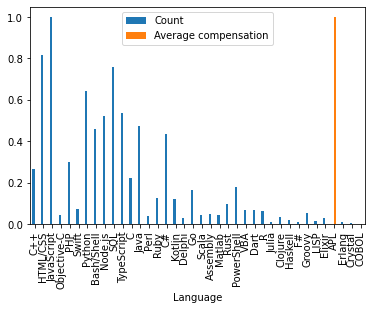

In [365]:
survey_2021.apply(lambda row: get_average_df(globaldf, row['LanguageHaveWorkedWith'],row['USDCompensation'],
                                                 'Language','Average compensation'), axis=1)

language_df = globaldf
display(language_df)
language_df[['Count', 'Average compensation']] = language_df[['Count', 'Average compensation']].apply(lambda column: (column - column.min()) / (column.max() - column.min()))
language_df.plot(x='Language', kind='bar')


#print(holis)

In [8]:
print(survey_2021['LanguageHaveWorkedWith'].value_counts(dropna=False))

HTML/CSS;JavaScript;Node.js;TypeScript                                                                                                                                                                                                               573
Python                                                                                                                                                                                                                                               548
C#;HTML/CSS;JavaScript;SQL                                                                                                                                                                                                                           417
HTML/CSS;JavaScript;PHP;SQL                                                                                                                                                                                                                          416
C#  

In [332]:
display(language_df)
survey_2021.CompFreq.value_counts()

if isinstance(language_df['Average compensation'].dtype, object):
    print("holis")
    
print(language_df['Average compensation'].dtype)

language_df.dtypes

#for label in c.currencies:
#    print(label)
#survey_2021.CompFreq.value_counts()
#print(survey_2021.Currency[0][:3])

language_df['Count'].max()
language_df.dtypes

Language Count  Average compensation
0          C++     2               23400.0
1     HTML/CSS     1                4800.0
2   JavaScript     1                4800.0
3  Objective-C     1                4800.0
4          PHP     1                4800.0
5        Swift     1                4800.0
6       Python     1               42000.0

holis
float64


Language                 object
Count                    object
Average compensation    float64
dtype: object

In [366]:
survey_2021.head()
survey_2021.dtypes
print(language_df['Count'].dtype)

language_df[['Count', 'Average compensation']] = language_df[['Count', 'Average compensation']].apply(lambda column: (column - column.min()) / (column.max() - column.min()))
display(language_df)

object


Language     Count  Average compensation
0           C++  0.268239          5.404744e-07
1      HTML/CSS  0.816143          4.330356e-09
2    JavaScript       1.0          4.815394e-06
3   Objective-C  0.041292          1.720551e-06
4           PHP  0.298988          1.868410e-07
5         Swift  0.073698          2.604352e-06
6        Python  0.643147          1.639049e-05
7    Bash/Shell  0.458937          1.012423e-05
8       Node.js  0.519905          9.804130e-06
9           SQL  0.757361          2.602344e-06
10   TypeScript  0.534046          6.332777e-07
11            C   0.22127          1.022551e-06
12         Java  0.472337          6.469250e-06
13         Perl  0.036955          2.609856e-06
14         Ruby   0.12444          1.476264e-06
15           C#  0.436934          4.964338e-07
16       Kotlin   0.11968          1.741714e-06
17       Delphi  0.028245          3.735406e-08
18           Go   0.16203          1.936402e-06
19        Scala  0.042279          8.333852e-07
20     Assembly  0.047992          2.390428e-06
21       Matlab  0.042773          1.048430e-06
22         Rust  0.094891          2.634465e-06
23   PowerShell  0.178462          1.515928e-06
24          VBA  0.066716          5.453604e-07
25         Dart  0.065799          0.000000e+00
26            R  0.062555          6.263462e-07
27        Julia  0.010967          1.246747e-06
28      Clojure  0.032124          2.679280e-06
29      Haskell  0.018865          2.248559e-07
30           F#  0.011742          1.219263e-06
31       Groovy  0.053211          1.376197e-06
32         LISP  0.012448          2.836185e-06
33       Elixir  0.029197          5.905397e-07
34          APL       0.0          1.000000e+00
35       Erlang  0.008216          2.183814e-06
36      Crystal   0.00268          1.942544e-06
37        COBOL  0.002363          3.336491e-07

<AxesSubplot:xlabel='Language'>

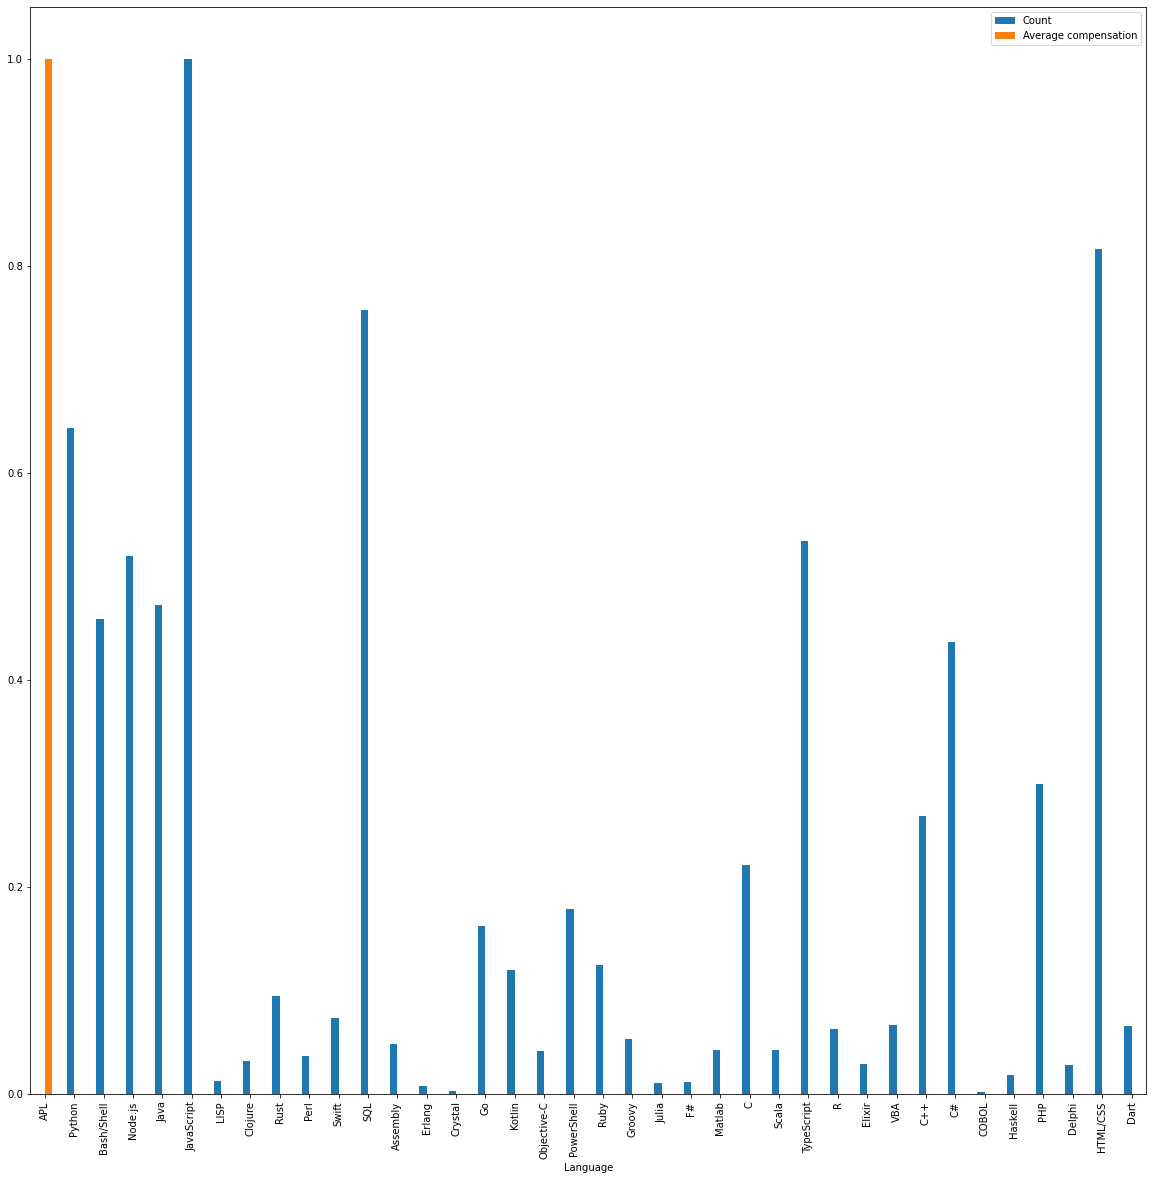

In [394]:
language_df.sort_values(by=['Average compensation'], inplace=True, ascending=False)
language_df.plot(x='Language', y=['Count','Average compensation'], kind='bar', width=0.5, figsize=(20,20))
#plt.bar(language_df['Language'], language_df['Count'])
#plt.bar(language_df['Language'], language_df['Average compensation'])
#plt.xlabel('Languages')
#plt.ylabel('Normalized value')
#plt.xticks(language_df['Language'], rotation='vertical')

AttributeError: 'Rectangle' object has no property 'legendsize'

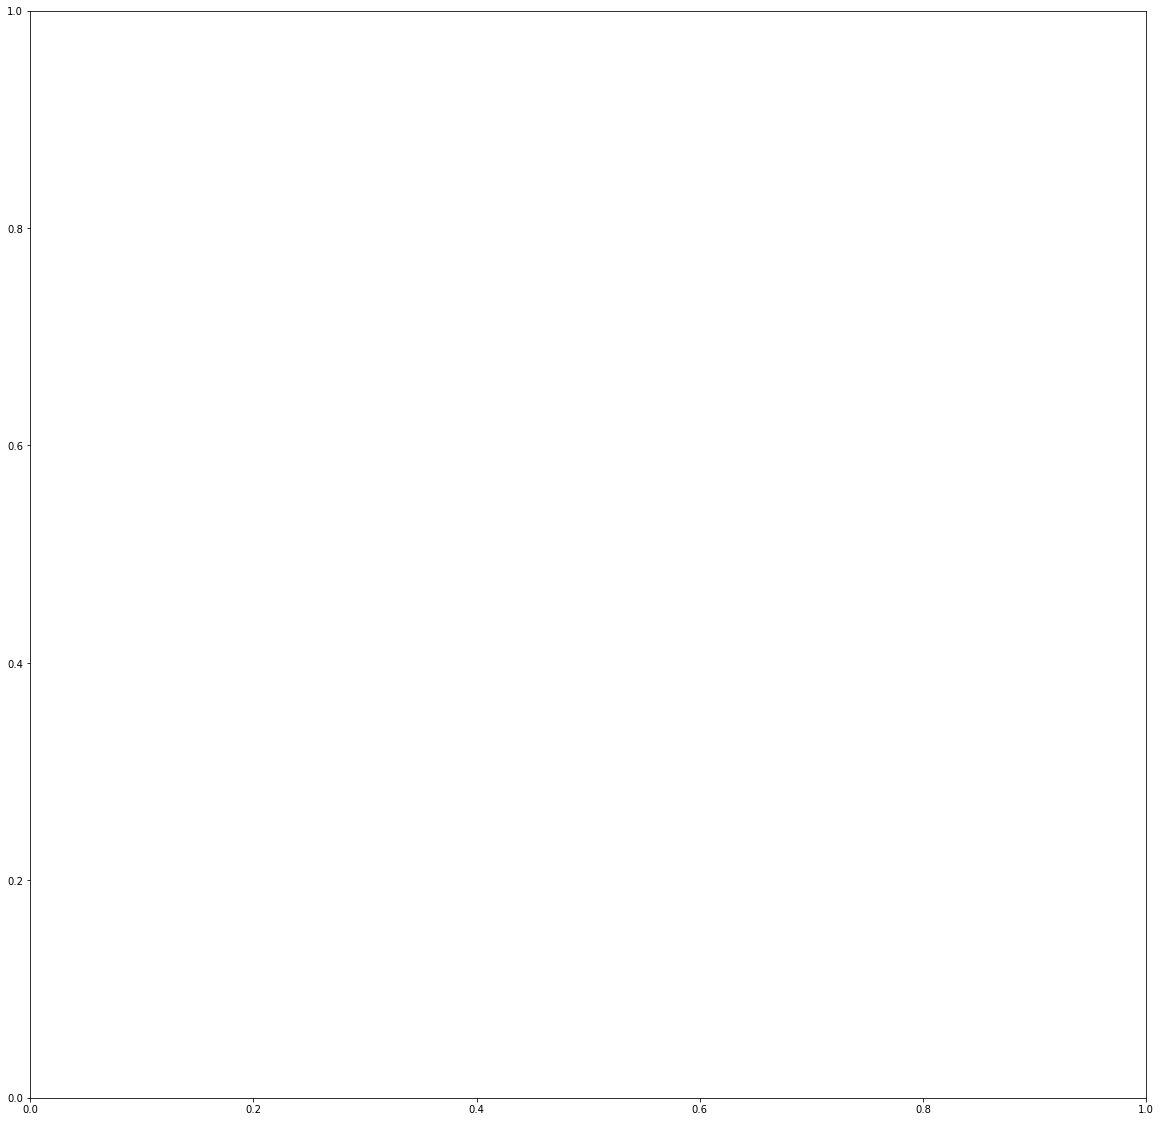

In [402]:
language_df2 = language_df.drop(language_df[language_df['Language'] == "APL"].index) 
language_df2[['Count', 'Average compensation']] = language_df2[['Count', 'Average compensation']].apply(lambda column: (column - column.min()) / (column.max() - column.min()))
language_df2.plot(x='Language', y=['Count','Average compensation'], kind='bar', width=0.8, figsize=(20,20))



